In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0))
])
traindata = MNIST(root = './dataset', download = True, train = True, transform = trans)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [98]:
testdata = MNIST(root = './dataset', download = True, train = False, transform = trans)

In [4]:
trainloader = DataLoader(traindata, batch_size = 256)
x, y = next(iter(trainloader))
print(x.shape)
print(y.shape)

torch.Size([256, 1, 28, 28])
torch.Size([256])


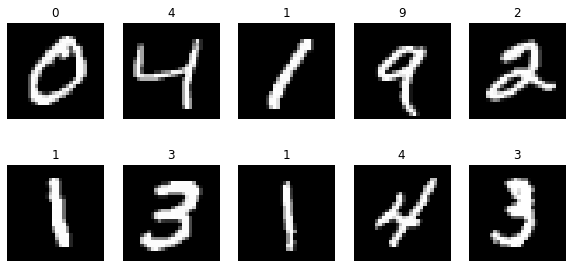

In [5]:
figure = plt.figure(figsize = (10, 10))
for i in range(1, 10+1):
    img, label = x[i], y[i].item()
    plt.subplot(4, 5, i)
    plt.imshow(img.squeeze(), cmap = 'gray')
    plt.axis('off')
    plt.title(label)

In [6]:
imgs, label = next(iter(trainloader))
layer1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5)
layer2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)

In [7]:
weight1 = layer1.weight[:, 0, :, :].detach().numpy()
weight2 = layer2.weight[:, 0, :, :].detach().numpy()

print(weight1.shape)
print(weight2.shape)

(6, 5, 5)
(16, 5, 5)


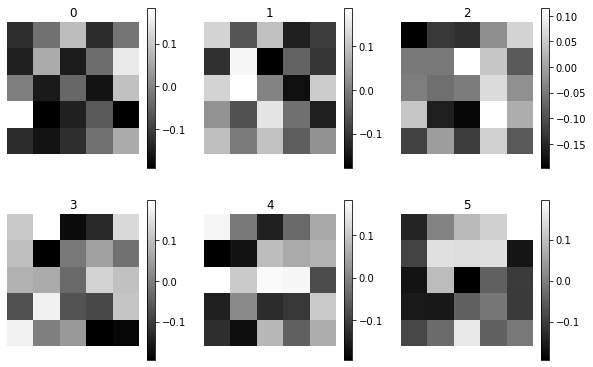

In [8]:
plt.figure(figsize = (10, 10))
for i in range(0, 5+ 1):
    plt.subplot(3, 3, i+1)
    plt.imshow(weight1[i], cmap = 'gray')
    plt.title(i)
    plt.axis('off')
    plt.colorbar()

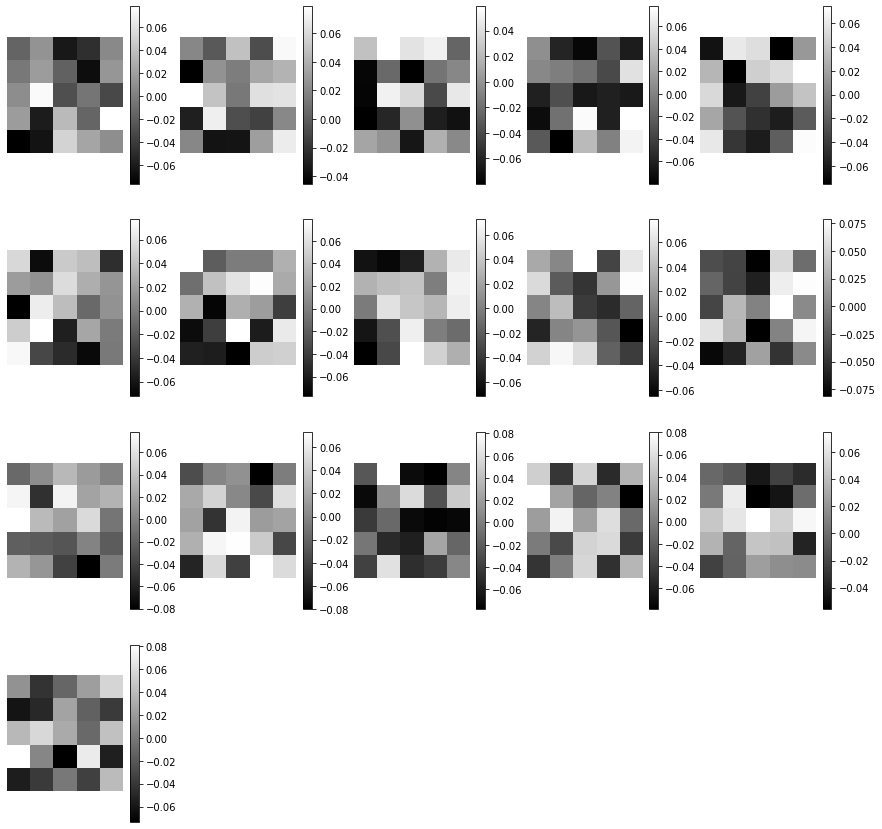

In [9]:
plt.figure(figsize = (15, 15))
for i in range(0, 15+1):
    plt.subplot(4, 5, i+1)
    plt.imshow(weight2[i], cmap = 'gray')
    plt.axis('off')
    plt.colorbar()

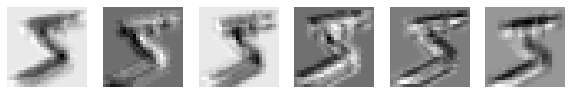

In [10]:
plot_imgs = layer1(imgs)[0, :, :, :].detach().numpy()

plt.figure(figsize = (10, 10))
for i in range(5+1):
    plt.subplot(1, 6, i+1)
    plt.imshow(plot_imgs[i], cmap = 'gray')
    plt.axis('off')

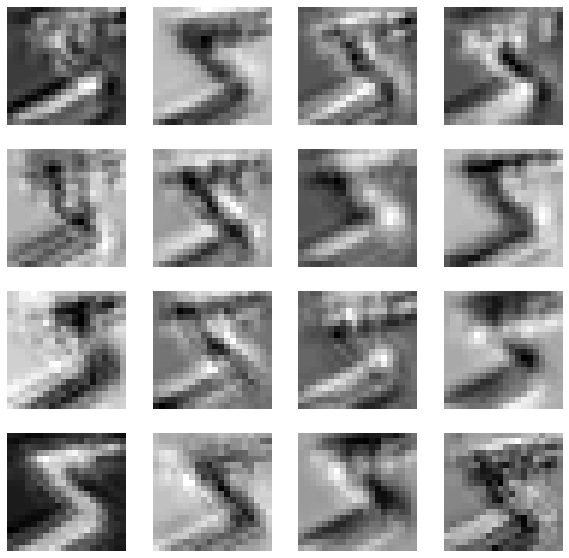

In [11]:
plot_imgs2 = layer2((layer1(imgs)))[0, :, :, :].detach().numpy()

plt.figure(figsize = (10, 10))
for i in range(15 + 1):
    plt.subplot(4, 4, i+1)
    plt.imshow(plot_imgs2[i], cmap = 'gray')
    plt.axis('off')

In [72]:
class Lenet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.c1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5)
        self.s2 = nn.MaxPool2d(2)
        self.c3 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
        self.s4 = nn.MaxPool2d(2)
        self.c5 = nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 4)
        self.fc1 = nn.Linear(1 * 1 * 120, 84)
        self.fc2 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = torch.tanh(self.c1(x))
        x = self.s2(x)
        x = torch.tanh(self.c3(x))
        x = self.s4(x)
        x = torch.tanh(self.c5(x))
        x = x.view(-1, 120)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x

In [146]:
model = Lenet().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
epochs = 10

In [122]:
from torchsummary import summary
summary(model, input_size = (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 120, 2, 2]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.17
Estimated Total Size (MB): 0.24
----------------------------------------------------------------


In [138]:
def accuracy_test(output, target):
  pred = output.argmax(dim = 1, keepdim = True)
  corrects = pred.eq(target.view_as(pred)).sum().item()
  return corrects

In [147]:
params = {'Train_Loss' :[],
          'Test_Loss' : [],
          'Train_Accuracy': [],
          'Test_Accuracy': []
          }

In [148]:
testloader = DataLoader(testdata, batch_size = 1)

In [149]:
len(testloader)

10000

In [150]:
for epoch in range(epochs):
    model.train()
    accuracy = 0

    for imgs, labels in trainloader:
        optim.zero_grad() 
        imgs = imgs.to(device)
        labels = labels.to(device)

        pred = model(imgs)
        
        loss = loss_fn(pred, labels)
        loss.backward()
        corrects = accuracy_test(pred, labels)
        acc_rate = corrects / len(imgs) * 100
        optim.step()

        model.eval()
        
        with torch.no_grad():
          test_epoch = 0
          for imgs, labels in testloader:
            test_epoch += 1
            imgs = imgs.to(device)
            labels = labels.to(device)
            pred = model(imgs)

            test_loss = loss_fn(pred, labels)

            test_corrects = accuracy_test(pred, labels)
            test_acc_rate = test_corrects / len(imgs) * 100
            
            if test_epoch == 100:
              break
            
    params['Train_Loss'].append(loss.item())
    params['Train_Accuracy'].append(acc_rate)
    params['Test_Loss'].append(test_loss.item())
    params['Test_Accuracy'].append(test_acc_rate)


        
        
    print('LOSS : ', loss.item(), 'ACC_RATE {:.2f}'.format(acc_rate), 'TEST_LOSS', test_loss, 'TEST_ACC_RATE :{:.2f}'.format(test_acc_rate))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


LOSS :  1.5355339050292969 ACC_RATE 90.62 TEST_LOSS tensor(1.5124, device='cuda:0') TEST_ACC_RATE :100.00
LOSS :  1.5001521110534668 ACC_RATE 96.88 TEST_LOSS tensor(1.4683, device='cuda:0') TEST_ACC_RATE :100.00
LOSS :  1.4941710233688354 ACC_RATE 97.92 TEST_LOSS tensor(1.4643, device='cuda:0') TEST_ACC_RATE :100.00
LOSS :  1.479962944984436 ACC_RATE 98.96 TEST_LOSS tensor(1.4631, device='cuda:0') TEST_ACC_RATE :100.00
LOSS :  1.4781643152236938 ACC_RATE 98.96 TEST_LOSS tensor(1.4623, device='cuda:0') TEST_ACC_RATE :100.00
LOSS :  1.4758728742599487 ACC_RATE 98.96 TEST_LOSS tensor(1.4619, device='cuda:0') TEST_ACC_RATE :100.00
LOSS :  1.4746392965316772 ACC_RATE 98.96 TEST_LOSS tensor(1.4616, device='cuda:0') TEST_ACC_RATE :100.00
LOSS :  1.473760724067688 ACC_RATE 98.96 TEST_LOSS tensor(1.4615, device='cuda:0') TEST_ACC_RATE :100.00
LOSS :  1.4731005430221558 ACC_RATE 98.96 TEST_LOSS tensor(1.4614, device='cuda:0') TEST_ACC_RATE :100.00
LOSS :  1.4725818634033203 ACC_RATE 98.96 TEST_L

In [151]:
params

{'Train_Loss': [1.5355339050292969,
  1.5001521110534668,
  1.4941710233688354,
  1.479962944984436,
  1.4781643152236938,
  1.4758728742599487,
  1.4746392965316772,
  1.473760724067688,
  1.4731005430221558,
  1.4725818634033203],
 'Test_Loss': [1.512384295463562,
  1.468292236328125,
  1.4643003940582275,
  1.4631404876708984,
  1.4623361825942993,
  1.4618699550628662,
  1.461599588394165,
  1.4614731073379517,
  1.461374282836914,
  1.4613165855407715],
 'Train_Accuracy': [90.625,
  96.875,
  97.91666666666666,
  98.95833333333334,
  98.95833333333334,
  98.95833333333334,
  98.95833333333334,
  98.95833333333334,
  98.95833333333334,
  98.95833333333334],
 'Test_Accuracy': [100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0]}

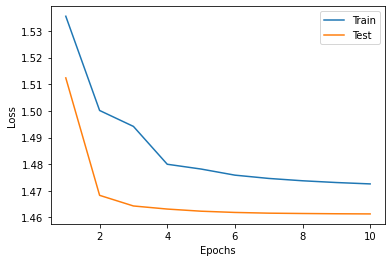

In [152]:
num_epoch = 10
plt.plot(range(1, 10+1), params['Train_Loss'],label = 'Train')
plt.plot(range(1, 10+1), params['Test_Loss'],label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

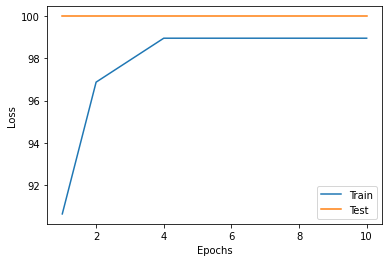

In [153]:
num_epoch = 10
plt.plot(range(1, 10+1), params['Train_Accuracy'],label = 'Train')
plt.plot(range(1, 10+1), params['Test_Accuracy'],label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()